<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models with Advanced Stats and TrackBoxStats</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Training Window](#Inspect-Training-Window)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_all_rolling_stats_merged_2021_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
# load the advanced stats and track box stats features
adv_stats = pd.read_csv('../../data/processed/nba_team_matchups_rolling_adv_stats_2021_2024_r05.csv')
track_box_stats = pd.read_csv('../../data/processed/nba_team_matchups_rolling_player_track_box_stats_2021_2024_r05.csv')

In [5]:
# exclude non-stat columns and combine advanced stats and track box stats features
omit_cols = ['GAME_ID', 'GAME_RESULT', 'TOTAL_PTS', 'PLUS_MINUS', 'HOME_TEAM_NAME', 'SEASON_ID', 'GAME_DATE', 'AWAY_TEAM_NAME']
adv_stats_filtered = adv_stats.drop(columns=[col for col in omit_cols if col in adv_stats.columns])
track_box_stats_filtered = track_box_stats.drop(columns=[col for col in omit_cols if col in track_box_stats.columns])
combined_adv_trackbox_df = pd.concat([adv_stats_filtered, track_box_stats_filtered], axis=1)

In [6]:
# subset the features to include only advanced stats and track box stats features
pts_adv_trackbox_features = pts_all_features[combined_adv_trackbox_df.columns.tolist() + ['TOTAL_PTS']]
pm_adv_trackbox_features = pm_all_features[combined_adv_trackbox_df.columns.tolist() + ['PLUS_MINUS']]
res_adv_trackbox_features = res_all_features[combined_adv_trackbox_df.columns.tolist() + ['GAME_RESULT']]

In [7]:
pts_adv_trackbox_features.head()

,ROLL_HOME_estimatedOffensiveRating,ROLL_HOME_offensiveRating,ROLL_HOME_estimatedDefensiveRating,ROLL_HOME_defensiveRating,ROLL_HOME_estimatedNetRating,ROLL_HOME_netRating,ROLL_HOME_assistPercentage,ROLL_HOME_assistToTurnover,ROLL_HOME_assistRatio,ROLL_HOME_offensiveReboundPercentage,ROLL_HOME_defensiveReboundPercentage,ROLL_HOME_reboundPercentage,ROLL_HOME_estimatedTeamTurnoverPercentage,ROLL_HOME_turnoverRatio,ROLL_HOME_effectiveFieldGoalPercentage,ROLL_HOME_trueShootingPercentage,ROLL_HOME_usagePercentage,ROLL_HOME_estimatedUsagePercentage,ROLL_HOME_estimatedPace,ROLL_HOME_pace,ROLL_HOME_pacePer40,ROLL_HOME_possessions,ROLL_HOME_PIE,ROLL_HOME_PTS,ROLL_AWAY_estimatedOffensiveRating,...,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.762,0.727,0.298,0.315,0.779,0.698,0.624,0.215,0.597,0.570,0.286,0.380,0.573,0.532,0.769,0.808,0.0,1.000,0.763,1.000,1.000,0.485,0.780,0.745,0.672,...,0.909,1.000,0.352,0.745,0.665,0.613,0.119,0.252,0.530,0.250,0.714,0.531,0.500,0.595,0.704,0.564,0.409,0.190,0.738,0.704,0.620,0.423,1.000,0.577,185
2021-10-23,0.000,0.000,0.176,0.192,0.286,0.242,0.201,0.000,0.000,0.620,0.679,0.408,0.617,0.595,0.000,0.000,0.0,0.875,0.732,0.909,0.909,0.455,0.000,0.000,0.183,...,0.909,0.655,0.762,0.000,0.619,0.387,0.489,0.409,0.579,0.125,0.179,0.517,0.083,0.000,0.458,0.000,0.364,0.453,0.301,0.000,0.185,0.269,0.453,0.096,198
2021-10-23,0.685,0.715,0.717,0.728,0.457,0.417,0.448,0.362,0.582,0.376,0.666,0.598,0.297,0.277,0.679,0.712,0.0,0.625,0.740,0.879,0.879,0.424,0.502,0.691,0.700,...,0.398,0.276,0.720,0.691,0.591,0.032,0.744,0.370,0.660,0.375,0.357,0.638,0.708,0.238,0.246,0.581,0.682,0.433,0.749,0.728,0.076,0.423,0.023,0.635,239
2021-10-23,0.849,0.987,0.328,0.402,0.827,0.833,0.719,1.000,0.888,0.955,0.197,0.542,0.055,0.046,0.739,0.683,0.0,0.750,0.367,0.242,0.242,0.121,0.787,0.727,0.279,...,0.455,0.586,0.291,0.727,0.715,0.452,0.460,0.409,0.460,0.375,0.179,0.403,0.208,0.357,0.282,0.735,0.136,0.372,0.075,0.225,0.511,0.346,0.965,0.250,232
2021-10-24,0.708,0.791,0.002,0.101,0.931,0.886,0.582,0.298,0.724,0.686,0.590,0.804,0.498,0.503,0.836,0.797,0.0,0.500,0.812,0.758,0.758,0.394,0.978,0.745,0.543,...,0.341,0.655,0.075,0.745,1.000,0.903,0.460,0.665,1.000,0.875,0.536,0.859,0.833,0.179,0.352,0.355,1.000,1.000,0.470,0.362,0.783,0.731,0.732,1.000,204


# Inspect Expanding Training Window

[Return to top](#Models)

In [8]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_adv_trackbox_features, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [9]:
# configuration for total points with expanding window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_adv_trackbox_features    # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
lr, model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    fitted_model=True
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 1131.39 seconds


In [10]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 18.90
- Null RMSE: 20.28


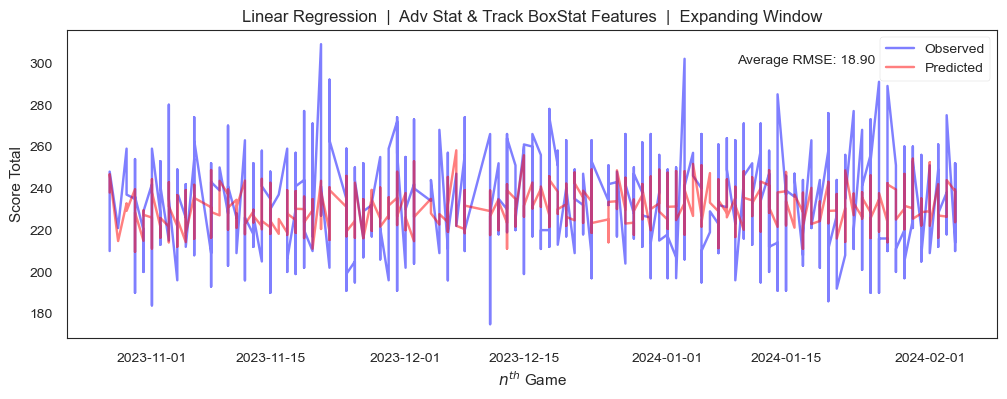

In [11]:
utl.plot_model_performance(
    title='Linear Regression  |  Adv Stat & Track BoxStat Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

In [12]:
# configuration for point difference with expanding window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_adv_trackbox_features     # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 42.83 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.43
- Null RMSE: 15.32


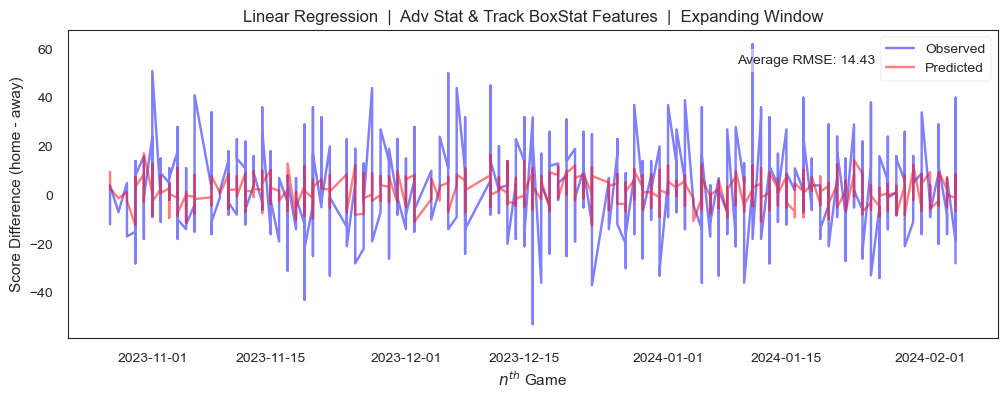

In [14]:
utl.plot_model_performance(
    title='Linear Regression  |  Adv Stat & Track BoxStat Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

In [15]:
# configuration for game winner with expanding window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_adv_trackbox_features    # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 83.32 seconds


In [16]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Baseline Accuracy: 0.56
- Average Accuracy: 0.64
- Overall AUC: 0.68
- Average F1 Score: 0.69


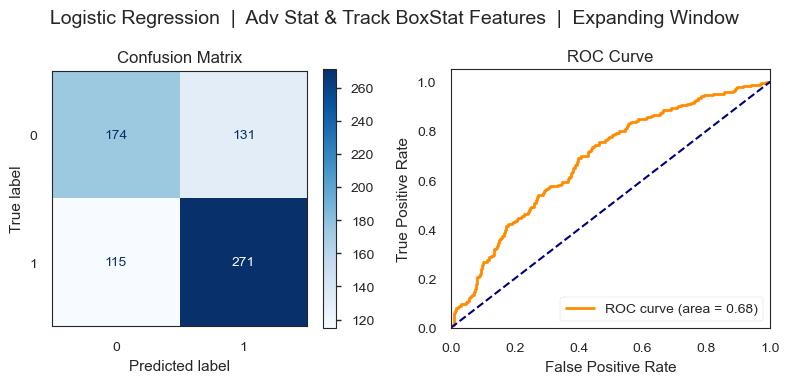

In [17]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Adv Stat & Track BoxStat Features  |  Expanding Window'
)